#### Credit Card Fraud Detection
* Download the dataset from the kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
* This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
* The objective is to detect credit card fraud from the given data.

Import require libraries

In [4]:
from library.preprocess.preprocess import preprocess
from library.feature_engineering.feature_selection import feature_selection
from library.feature_engineering.hyper_params_tune import hyper_params_tune
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import metrics
import os

Current directory

In [5]:
current_dir = os.getcwd()

Read data

In [6]:
file_path = os.path.join(current_dir,"storage/input/creditcard.csv")

df = pd.read_csv(file_path)
# print content information in df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Check whether there are missing value in dataset

In [7]:
pre_process = preprocess()
result = pre_process.check_missingvalue(df)
print("Are there missing value in dataset: ", result['HasMissingValue'])

Are there missing value in dataset:  False


Check for class balance or imbalance

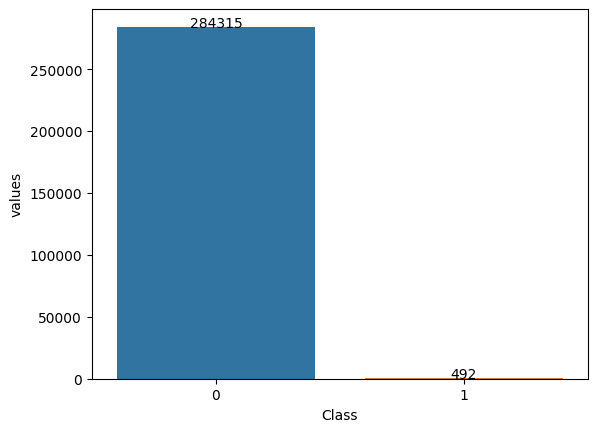

In [8]:
# Counts unique class value
class_ = df["Class"].value_counts()
class_ = pd.DataFrame({'Class': class_.index,'values': class_.values})
# plot bar chart of different class count
ax = sns.barplot(x = 'Class', y = 'values', data = class_)
# Add values above bars
for i, v in enumerate(class_['values']):
   ax.text(i, v + 0.3, str(v), ha='center')
# Show the plot
plt.show()

* From above bar chart there are more number of class 0 samples than class 1. Hence, the dataset is unbalance.

Split dataset into train and test data
* Training = 70% and Test = 30%

In [9]:
# Get column name
column_headers = list(df.columns.values)
# remove class from the list
column_headers.remove("Class")

X=df.drop(["Class"],axis=1).values
y=df["Class"].values

# Split training and test data using sklearn train test split (training data=70% and test data=30%)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

X_train = pd.DataFrame(X_train, columns=column_headers)
X_test = pd.DataFrame(X_test, columns=column_headers)

y_train = pd.DataFrame(y_train, columns=['label'])
y_test = pd.DataFrame(y_test, columns=['label'])

Normalized train and test data

In [10]:
# Normalize data
normalize_model, normalize_warn = pre_process.normalization_fit(data=X_train, normalization_method='robustscaler')
X_train_normalize ,transform_warn = pre_process.model_transform(normalize_model['scaler'], X_train)
X_train_transformed = X_train_normalize['transformed_x']

X_test_normalize, transform_warn = pre_process.model_transform(normalize_model['scaler'], X_test)
X_test_transformed = X_test_normalize['transformed_x']

Select suitable features from 31 features dimension by using XGBoost to minimize curse of dimensionality

In [ ]:
features_selection= feature_selection()
# Features selection
feature_select = features_selection.feature_selection(data=X_train_transformed, label=y_train)

In [12]:
print('Full features importance scores ...')
print(feature_select['full_features_importance_scores'])

Full features importance scores ...
   Feature  Feature importance
0      V14            0.449287
1       V4            0.066729
2       V8            0.044945
3      V12            0.039442
4   Amount            0.026447
5      V20            0.024062
6      V19            0.021699
7       V3            0.018900
8      V27            0.018710
9       V2            0.018689
10     V22            0.018411
11     V17            0.017795
12     V26            0.017179
13      V7            0.016992
14      V1            0.016682
15     V10            0.016401
16     V25            0.016363
17     V18            0.015675
18     V24            0.015647
19      V6            0.015208
20      V5            0.014666
21     V23            0.014283
22     V13            0.012647
23     V28            0.012133
24     V15            0.011815
25      V9            0.009582
26    Time            0.008354
27     V21            0.008246
28     V11            0.007651
29     V16            0.005361


In [13]:
# Top 20 features
print('Selected features ...')
print(feature_select['selected_features_names'])

Selected features ...
['V14', 'V4', 'V8', 'V12', 'Amount', 'V20', 'V19', 'V3', 'V27', 'V2', 'V22', 'V17', 'V26', 'V7', 'V1', 'V10', 'V25', 'V18', 'V24', 'V6']


In [14]:
X_train_selected_feats = X_train_transformed[feature_select['selected_features_names']]
X_test_seleccted_feats = X_test_transformed[feature_select['selected_features_names']]

XGBoost model Hyper paramerters tune and saved tuned hyper parameters.

* Since the dataset is imbalance, RepeatedStratifiedKFold crosss validation method is used to fine tune the hyperparameters of xgboost classifier.
* The StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

In [15]:
file_path = os.path.join(current_dir,"storage/output/creditcard_xgb_best_params.csv")
if os.path.exists(file_path):
    # Read best parameters
    best_params = pd.read_csv(file_path)
    n_estimators = best_params['n_estimators'].iloc[0]
    max_depth = best_params['max_depth'].iloc[0]
    eta = best_params['eta'].iloc[0]
else:
    hpt= hyper_params_tune()
    # Parameters to be tunes
    params = {'eta': [0.001, 0.01, 0.1, 1.0],
            'n_estimators': [10, 50, 100, 500, 1000, 5000],
            'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
    # model
    xgb_classifier = XGBClassifier()
    params = hpt.tune(data=X_train_selected_feats, label=y_train, params=params, model=xgb_classifier)
    # extract best parameters
    n_estimators = params['n_estimators']
    max_depth = params['max_depth']
    eta = params['eta']
    # Save best parameters
    best_params = pd.DataFrame([params])
    best_params.to_csv(os.path.join(current_dir,"storage/output/creditcard_xgb_best_params.csv"))

Train XGBoost classifier
* Weighted sample loss method was used to train XGBoost model because dataset is imbalanced. 
* The technique assigned different weights to each class based on the number of samples in the class. 
* The purpose of weighted sample loss is to avoid the model from being biased toward the majority class by giving the minority class greater weight during training.

In [ ]:
# train xgboost classifier
xgb_classifier = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, eta=eta)
label= y_train.values.flatten() # flatten array to be (nsample,)
xtrain = X_train_selected_feats.values
sample_weights = compute_sample_weight(class_weight='balanced',y=label) #provide your own target name
xgb_classifier.fit(xtrain,label,sample_weight=sample_weights)

In [17]:
# Train predict
ytrain_predict = xgb_classifier.predict(X_train_selected_feats.values)
# Test predict
ytest_predict = xgb_classifier.predict(X_test_seleccted_feats.values)

# Calculate accuracy
ytrain = y_train.values.flatten()
print('Train balanced accuracy: ',balanced_accuracy_score(ytrain, ytrain_predict))

ytest = y_test.values.flatten()
print('Test balanced accuracy: ',balanced_accuracy_score(ytest, ytest_predict))

# Calculate precision
print('Train precision: ',precision_score(ytrain, ytrain_predict, average='macro'))
print('Test precision: ',precision_score(ytest, ytest_predict, average='macro'))
# Calculate recall
print('Train recall: ',recall_score(ytrain, ytrain_predict, average='macro'))
print('test recall: ',recall_score(ytest, ytest_predict, average='macro'))
# Calculate f1-score
print('Train f1-score: ',f1_score(ytrain, ytrain_predict, average='macro'))
print('Test f1-score: ',f1_score(ytest, ytest_predict, average='macro'))

Train balanced accuracy:  1.0
Test balanced accuracy:  0.9264295599492214
Train precision:  1.0
Test precision:  0.9714275096337461
Train recall:  1.0
test recall:  0.9264295599492214
Train f1-score:  1.0
Test f1-score:  0.9477973279247405


Plot AUROC curve

AUROC of training phase:  1.0
AUROC of test phase:  0.9865704765969829


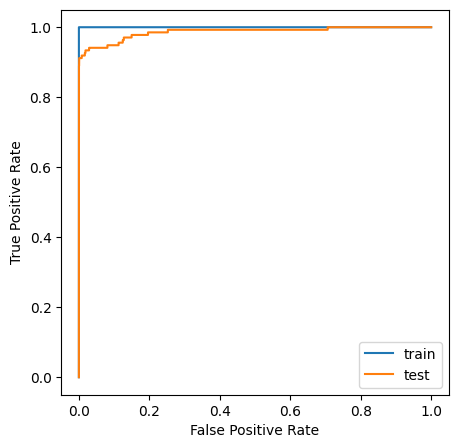

In [18]:
# Train
ytrain_pred_proba = xgb_classifier.predict_proba(X_train_selected_feats)[::,1]
fpr_train, tpr_train, _ = metrics.roc_curve(ytrain,  ytrain_pred_proba)

print("AUROC of training phase: ", metrics.auc(fpr_train, tpr_train))

# Test
ytest_pred_proba = xgb_classifier.predict_proba(X_test_seleccted_feats)[::,1]
fpr_test, tpr_test, _ = metrics.roc_curve(ytest,  ytest_pred_proba)

print("AUROC of test phase: ", metrics.auc(fpr_test, tpr_test))

#create ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr_train,tpr_train, label='train')
plt.plot(fpr_test, tpr_test, label='test')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

References:
1. 3.1. Cross-validation: evaluating estimator performance. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/cross_validation.html#repeated-k-fold

2. What is Weighted Sample Loss in Keras Tensorflow? | Saturn Cloud Blog. (2023, August 25). https://saturncloud.io/blog/what-is-weighted-sample-loss-in-keras-tensorflow/#:~:text=In%20conclusion%2C%20weighted%20sample%20loss,biased%20towards%20the%20majority%20class.

3. Brownlee, J. (2020). How to configure XGBOOST for imbalanced Classification. MachineLearningMastery.com. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

4. XGBoost for multiclassification and imbalanced data. (n.d.). Stack Overflow. https://stackoverflow.com/questions/67868420/xgboost-for-multiclassification-and-imbalanced-data

5. Python API Reference — xgboost 1.7.6 documentation. (n.d.). https://xgboost.readthedocs.io/en/stable/python/python_api.html

6. Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

7. Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

8. Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

9. Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

10. Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

11. Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

12. Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

13. Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019

14. Yann-Aël Le Borgne, Gianluca Bontempi Reproducible machine Learning for Credit Card Fraud Detection - Practical Handbook

15. Bertrand Lebichot, Gianmarco Paldino, Wissam Siblini, Liyun He, Frederic Oblé, Gianluca Bontempi Incremental learning strategies for credit cards fraud detection, IInternational Journal of Data Science and Analytics